<a href="https://colab.research.google.com/github/alesanchez14/A-B-testing-using-Machine-Learning/blob/main/A/B_Testing_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Packages**

In [1]:
import pandas as pd  # Equivalent to tidyverse for data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For statistical data visualization
import sklearn  # Equivalent to parsnip, recipes, rsample, yardstick, and broom for modeling and evaluation
import xgboost  # Same library exists in Python
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder


**Data Loading**

In [2]:
control_tbl = pd.read_csv('control_data.csv')
experiment_tbl = pd.read_csv('experiment_data.csv')

In [3]:
#Showing the first 5 rows of control_tbl
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


We have 5 columns consisting of:

-  Date: a character formatted Day, Month, and Day of Month

- Pageviews: An aggregated count of Page Views on the given day

- Clicks: An aggregated count of Page Clicks on the given day for the page in question

- Enrollments: An aggregated count of Enrollments by day.

- Payments: An aggregated count of Payments by day.

**Data Format**

In [4]:
# Displaying basic information about the dataframes
print("Control Table Info:")
print(control_tbl.info())
print("\nExperiment Table Info:")
print(experiment_tbl.info())


Control Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
None

Experiment Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB
None


In [5]:
# Displaying the total number of observations
print(f"\nTotal observations in control set: {len(control_tbl)}")
print(f"Total observations in experiment set: {len(experiment_tbl)}")


Total observations in control set: 37
Total observations in experiment set: 37


In [6]:
# Displaying that the data formats between the control and experiment groups are the same
print("\nData format between control and experiment groups is the same.")

# Verifying that the number of observations is the same since the groups were tested in parallel
print(f"Same number of observations ({len(control_tbl)} days) since the groups were tested in parallel.")



Data format between control and experiment groups is the same.
Same number of observations (37 days) since the groups were tested in parallel.


In [7]:
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


- The control set and the experiment set each comprise 37 observations.
- The data is organized based on time and is aggregated daily, although this format may not be ideal for analyzing complex user behaviors.
- The 'Date' column is formatted as a character data type, which will be a significant point when addressing data quality. We plan to extract the 'day of the week' features from this column.
- Both the experiment and control groups have data in identical formats, with the same number of observations over 37 days, as the groups were tested concurrently.

**Exploratory Data Analysis (EDA)**

In [8]:
# Calculating the amount of missing values per column in control_tbl
missing_count_control = control_tbl.isnull().sum().reset_index()
missing_count_control.columns = ['feature', 'missing_count']
missing_count_control = missing_count_control.sort_values(by='missing_count', ascending=False)
print(missing_count_control)


       feature  missing_count
3  Enrollments             14
4     Payments             14
0         Date              0
1    Pageviews              0
2       Clicks              0


In [9]:
# Calculating the amount of missing values per column in experiment_tbl
missing_count_experiment = experiment_tbl.isnull().sum().reset_index()
missing_count_experiment.columns = ['feature', 'missing_count']
missing_count_experiment = missing_count_experiment.sort_values(by='missing_count', ascending=False)
print(missing_count_experiment)

       feature  missing_count
3  Enrollments             14
4     Payments             14
0         Date              0
1    Pageviews              0
2       Clicks              0


Key Point: We have 14 days of missing observations that we need to investigate.

The missing data (NA) is consistent in the experiment set.

Let’s see which values are missing

In [45]:
# Filtering rows where the Enrollments column is NA in control_tbl
control_na_enrollments = control_tbl[control_tbl['Enrollments'].isnull()]
print(control_na_enrollments)

           Date  Pageviews  Clicks  Enrollments  Payments
23   Mon, Nov 3       9437     788          NaN       NaN
24   Tue, Nov 4       9420     781          NaN       NaN
25   Wed, Nov 5       9570     805          NaN       NaN
26   Thu, Nov 6       9921     830          NaN       NaN
27   Fri, Nov 7       9424     781          NaN       NaN
28   Sat, Nov 8       9010     756          NaN       NaN
29   Sun, Nov 9       9656     825          NaN       NaN
30  Mon, Nov 10      10419     874          NaN       NaN
31  Tue, Nov 11       9880     830          NaN       NaN
32  Wed, Nov 12      10134     801          NaN       NaN
33  Thu, Nov 13       9717     814          NaN       NaN
34  Fri, Nov 14       9192     735          NaN       NaN
35  Sat, Nov 15       8630     743          NaN       NaN
36  Sun, Nov 16       8970     722          NaN       NaN


In [46]:
# Filtering rows where the Enrollments column is NA in control_tbl
experiment_na_enrollments = experiment_tbl[experiment_tbl['Enrollments'].isnull()]
print(experiment_na_enrollments)


           Date  Pageviews  Clicks  Enrollments  Payments
23   Mon, Nov 3       9359     789          NaN       NaN
24   Tue, Nov 4       9427     743          NaN       NaN
25   Wed, Nov 5       9633     808          NaN       NaN
26   Thu, Nov 6       9842     831          NaN       NaN
27   Fri, Nov 7       9272     767          NaN       NaN
28   Sat, Nov 8       8969     760          NaN       NaN
29   Sun, Nov 9       9697     850          NaN       NaN
30  Mon, Nov 10      10445     851          NaN       NaN
31  Tue, Nov 11       9931     831          NaN       NaN
32  Wed, Nov 12      10042     802          NaN       NaN
33  Thu, Nov 13       9721     829          NaN       NaN
34  Fri, Nov 14       9304     770          NaN       NaN
35  Sat, Nov 15       8668     724          NaN       NaN
36  Sun, Nov 16       8988     710          NaN       NaN


We don’t have Enrollment information from November 3rd on. We will need to remove these observations.

In [47]:
print(control_tbl.head(5))

          Date  Pageviews  Clicks  Enrollments  Payments
0  Sat, Oct 11       7723     687        134.0      70.0
1  Sun, Oct 12       9102     779        147.0      70.0
2  Mon, Oct 13      10511     909        167.0      95.0
3  Tue, Oct 14       9871     836        156.0     105.0
4  Wed, Oct 15      10014     837        163.0      64.0


- Date is in character format. It doesn’t contain year information. Since the experiment was only run for 37 days, we can only realistically use the “Day of Week” as a predictor.

- The other columns are all numeric, which is OK. We will predict the number of Enrollments

- Payments is an outcome of Enrollments so this should be removed.

**Data Cleaning**

- Combine the control_tbl and experiment_tbl, adding an “id” column indicating if the data was part of the experiment or not

- Add a “row_id” column to help for tracking which rows are selected for training and testing in the modeling section

- Create a “Day of Week” feature from the “Date” column

- Drop the unnecessary “Date” column and the “Payments” column

- Handle the missing data (NA) by removing these rows.

- Shuffle the rows to mix the data up for learning

- Reorganize the columns

In [14]:
# Setting the seed for reproducibility
np.random.seed(123)

# Combining the control and experiment data
data_formatted_tbl = pd.concat([control_tbl.assign(Experiment=0),
                                experiment_tbl.assign(Experiment=1)],
                               ignore_index=True)

# Adding a row_id column
data_formatted_tbl['row_id'] = data_formatted_tbl.index + 1

# Creating a "Day of Week" feature from the "Date" column
# Assuming the date is in the format 'Sat, Oct 11'
data_formatted_tbl['DOW'] = data_formatted_tbl['Date'].str.split(',').str[0]

# Remove Date and Payments columns
del data_formatted_tbl['Date'], data_formatted_tbl['Payments']

# Remove missing data
data_formatted_tbl.dropna(inplace=True)

# Shuffle the data
data_total = sklearn.utils.shuffle(data_formatted_tbl)

# Reordering the columns so that "DOW" is after "Experiment"
columns = ['row_id', 'Enrollments', 'Experiment', 'DOW', 'Pageviews', 'Clicks']
data_formatted_tbl = data_formatted_tbl[columns]




In [15]:
print(data_formatted_tbl.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 59
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       46 non-null     int64  
 1   Enrollments  46 non-null     float64
 2   Experiment   46 non-null     int64  
 3   DOW          46 non-null     object 
 4   Pageviews    46 non-null     int64  
 5   Clicks       46 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.5+ KB
None


**Machine Learning Models**

We are going to implement 3 modeling approaches:

- Linear Regression

- Decision Tree

- XGBoost

**Preparing the data for the model**

In [16]:
# Splitting the data
train_tbl, test_tbl = train_test_split(data_formatted_tbl, test_size=0.2, stratify=data_formatted_tbl['Experiment'], random_state=123)

print("\nTraining Data:")
print(train_tbl.info())
print("\nTesting Data:")
print(test_tbl.info())


Training Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 42 to 8
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       36 non-null     int64  
 1   Enrollments  36 non-null     float64
 2   Experiment   36 non-null     int64  
 3   DOW          36 non-null     object 
 4   Pageviews    36 non-null     int64  
 5   Clicks       36 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.0+ KB
None

Testing Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 39 to 2
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       10 non-null     int64  
 1   Enrollments  10 non-null     float64
 2   Experiment   10 non-null     int64  
 3   DOW          10 non-null     object 
 4   Pageviews    10 non-null     int64  
 5   Clicks       10 non-null     int64  
dtypes: float64(1), int64(

In [30]:
# Drop the 'row_id' and 'Enrollments' columns from X_train and X_test
X_train = train_tbl.drop(columns=['row_id', 'Enrollments'])
X_test = test_tbl.drop(columns=['row_id', 'Enrollments'])

# The labels (y_train and y_test) remain the same as before
y_train = train_tbl['Enrollments']
y_test = test_tbl['Enrollments']


lb = LabelEncoder()
X_train['DOW'] = lb.fit_transform(X_train['DOW'])
X_test['DOW'] = lb.transform(X_test['DOW'])

**Linear Regression**

In [18]:
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))


set()
set()


In [19]:
# Fitting the linear regression model
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model_lm.predict(X_test)

# Calculating the metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Square Error
r2 = r2_score(y_test, y_pred)  # R-squared
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

# Creating a DataFrame to display the metrics
metrics_df = pd.DataFrame({'Metric': ['RMSE', 'R-squared', 'MAE'],
                           'Value': [rmse, r2, mae]})

# Displaying the DataFrame
print(metrics_df)





      Metric      Value
0       RMSE  25.407516
1  R-squared   0.449666
2        MAE  19.314832


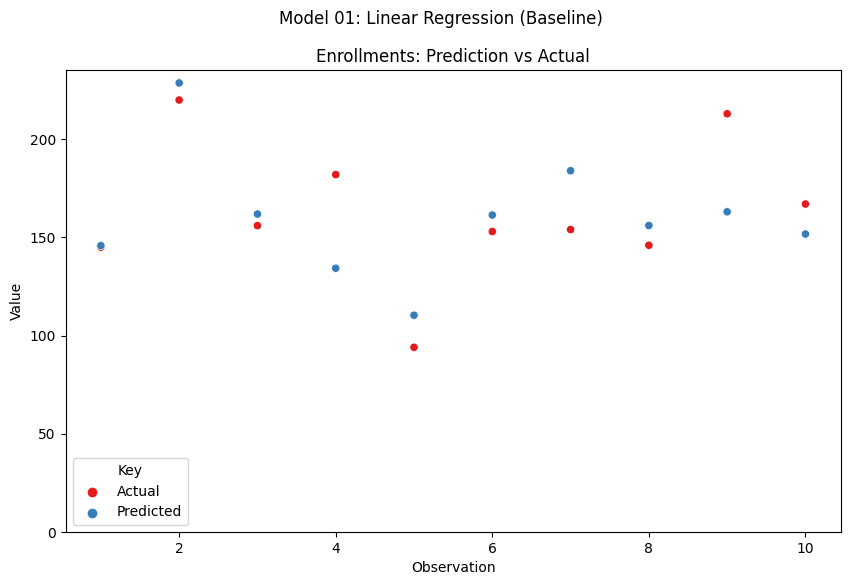

In [20]:
# Assuming y_pred is the vector of predictions and y_test is the vector of actual values
predictions_df = pd.DataFrame({'Observation': range(1, len(y_test) + 1),
                               'Actual': y_test.values,
                               'Predicted': y_pred})

# Transforming the DataFrame for visualization
predictions_melted = predictions_df.melt(id_vars='Observation', var_name='Key', value_name='Value')

# Visualizing the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_melted, x='Observation', y='Value', hue='Key', palette='Set1')
plt.ylim(bottom=0)  # To expand the y-axis limits
plt.title('Enrollments: Prediction vs Actual')
plt.suptitle('Model 01: Linear Regression (Baseline)')
plt.show()


In [21]:
import statsmodels.api as sm


# Asumiendo que X_train y y_train son tus datos de entrenamiento
# Añadir una constante (i.e., bias o intercepto) a X_train
X_train_const = sm.add_constant(X_train)

# Ajustar el modelo
model_lm = sm.OLS(y_train, X_train_const).fit()

# Obteniendo un resumen del modelo en un DataFrame
summary_df = model_lm.summary2().tables[1]

# Ordenando el DataFrame por p-value
summary_df_sorted = summary_df.sort_values(by='P>|t|')
# Para mostrar el DataFrame de una manera más bonita, puedes usar el método to_html
print(summary_df_sorted)


                Coef.   Std.Err.         t     P>|t|     [0.025      0.975]
Pageviews    0.062856   0.011572  5.431912  0.000006   0.039255    0.086456
Clicks      -0.611624   0.136013 -4.496802  0.000090  -0.889025   -0.334224
Experiment -19.277786   7.632705 -2.525682  0.016873 -34.844792   -3.710781
const       47.361653  45.036829  1.051621  0.301103 -44.491565  139.214870
DOW         -0.349102   2.230342 -0.156524  0.876635  -4.897914    4.199710


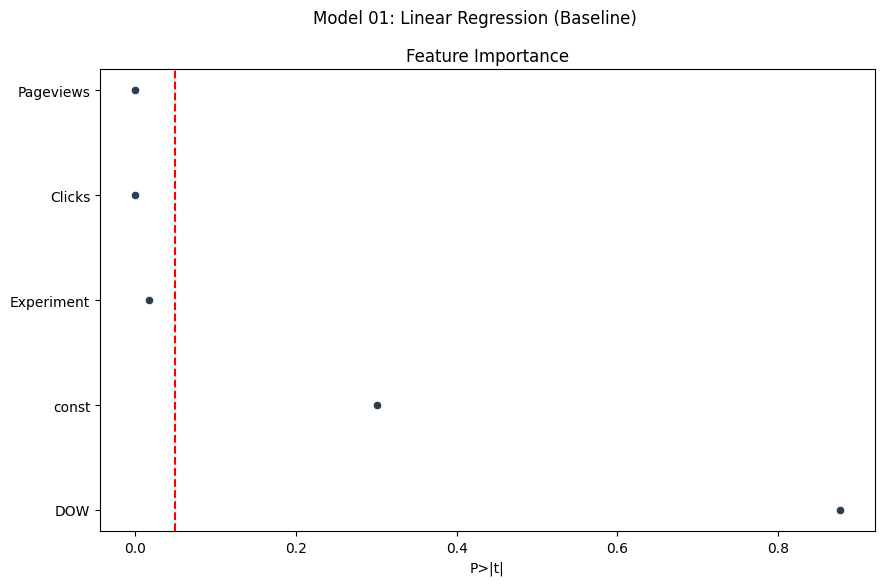

In [22]:
# Visualizando la importancia de las características
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df_sorted, x='P>|t|', y=summary_df_sorted.index, color='#2C3E50')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.title('Feature Importance')
plt.suptitle('Model 01: Linear Regression (Baseline)')
plt.show()


In [23]:
pd.DataFrame(model_lm.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
3,Pageviews,0.000006
4,Clicks,0.000090
1,Experiment,0.016873
0,const,0.301103
2,DOW,0.876635


Decision Tree

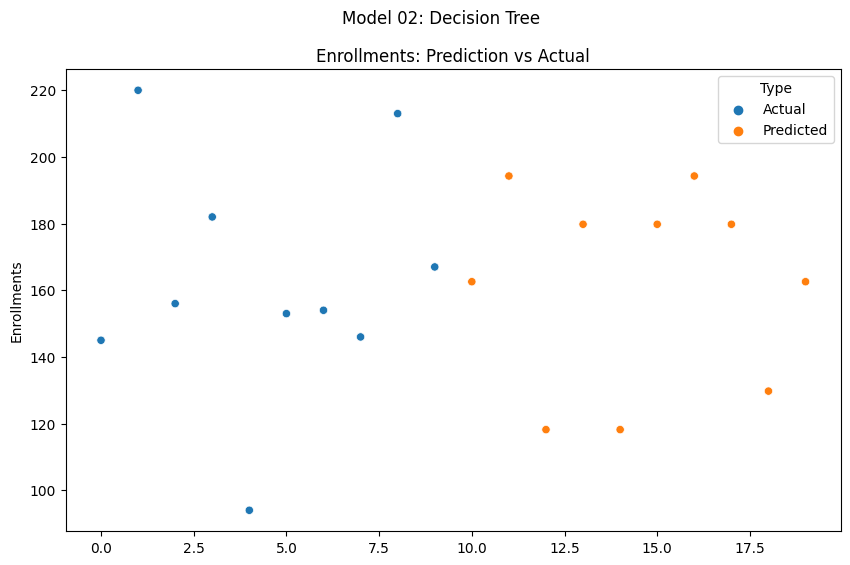

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns



# Create the decision tree regressor
model_02_decision_tree = DecisionTreeRegressor(ccp_alpha=0.001, max_depth=5, min_samples_leaf=4)
model_02_decision_tree.fit(X_train, y_train)

# Make predictions
y_pred = model_02_decision_tree.predict(X_test)

# Create a DataFrame to hold the actual and predicted values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Melt the DataFrame for easier plotting
predictions_melted = predictions_df.melt(value_name='Enrollments', var_name='Type')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions_melted, x=predictions_melted.index, y='Enrollments', hue='Type')
plt.title('Enrollments: Prediction vs Actual')
plt.suptitle('Model 02: Decision Tree')
plt.show()

